# 카카오-구름 AI 프로젝트
## 모델링(Modelling) - Colab ver.

In [1]:
# 활용 library
from __future__ import print_function, division
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [2]:
# GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# (1) Data preprocession and augmentation

#이미지 크기
img_size = 224

#데이터 증강 파라미터
random_crop_scale = (0.7, 1.0)
random_flip_prob = 0.5
random_rotation_degrees = (-30, 30)

#데이터 split 비율
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

#배치 크기
train_batch_size = 16
val_batch_size = 4
test_batch_size = 4

#데이터 증강 및 전처리
uxo_transform = transforms.Compose([
    transforms.RandomResizedCrop((img_size, img_size), scale=random_crop_scale),
    transforms.RandomHorizontalFlip(p=random_flip_prob),
    transforms.RandomRotation(degrees=random_rotation_degrees),
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize, ImageNet에서 계산된 값
])

#이미지 로드, 폴더명을 클래스로
path = "D:/Working_Directory/project_0912/data"
dataset = ImageFolder(path, transform=uxo_transform)

In [4]:
# Data Split
dataset_size = len(dataset)

train_size = int(dataset_size * train_ratio)
val_size = int(dataset_size * val_ratio)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(val_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

#DataLoader 생성
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, drop_last=True)

class_names = dataset.classes

Training Data Size : 9937
Validation Data Size : 2839
Testing Data Size : 1421


## ResNet-18

In [6]:
# (2) Modelling

# 1. ResNet-18 모델 불러오기 (pre-trained 모델)
model = torchvision.models.resnet18(pretrained=True)

# 모델의 마지막 fully connected layer를 변경하여 클래스 수에 맞게 조정
num_classes = len(class_names)  # 클래스 수에 맞게 설정
model.fc = nn.Linear(model.fc.in_features, num_classes)

# GPU를 사용할 수 있다면 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# epochs, learning rate
num_epochs = 50
learning_rate = 0.001

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss, acc
train_losses = [] ;val_losses = []
train_accuracy = [] ;val_accuracy = []

# 모델 학습
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 30)

    # 학습 모드로 설정
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # tqdm으로 래핑한 데이터 로더
    train_dataloader = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch [{epoch+1}/{num_epochs}] - Train')

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # tqdm 업데이트 (진행률 표시)
        train_dataloader.set_postfix(loss=running_train_loss / (len(train_dataloader)), acc=correct_train / total_train)

    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy.append(correct_train / total_train)
    train_losses.append(epoch_train_loss)

    # 평가 모드로 설정
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_accuracy.append(correct_val / total_val)
    val_losses.append(epoch_val_loss)

    # 모델 체크포인트 저장 (필요한 경우)
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }
    checkpoint_path = "D:/Working_Directory/project_0912/data/checkpoint.pth"
    torch.save(checkpoint, checkpoint_path)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {train_accuracy[-1]:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {val_accuracy[-1]:.4f}')
    print('=' * 30)

C:\Users\Minwoo\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/49
------------------------------


Epoch [1/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:31<00:00,  1.87it/s, acc=0.747, loss=0.523]


Epoch [1/50] - Train Loss: 0.5230 - Train Accuracy: 0.7473
Epoch [1/50] - Val Loss: 0.4749 - Val Accuracy: 0.7348
Epoch 1/49
------------------------------


Epoch [2/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:16<00:00,  1.96it/s, acc=0.79, loss=0.441]


Epoch [2/50] - Train Loss: 0.4411 - Train Accuracy: 0.7901
Epoch [2/50] - Val Loss: 0.4420 - Val Accuracy: 0.7782
Epoch 2/49
------------------------------


Epoch [3/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:16<00:00,  1.96it/s, acc=0.799, loss=0.425]


Epoch [3/50] - Train Loss: 0.4252 - Train Accuracy: 0.7991
Epoch [3/50] - Val Loss: 0.5058 - Val Accuracy: 0.7786
Epoch 3/49
------------------------------


Epoch [4/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.821, loss=0.396]


Epoch [4/50] - Train Loss: 0.3957 - Train Accuracy: 0.8207
Epoch [4/50] - Val Loss: 0.3924 - Val Accuracy: 0.8290
Epoch 4/49
------------------------------


Epoch [5/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.826, loss=0.385]


Epoch [5/50] - Train Loss: 0.3848 - Train Accuracy: 0.8264
Epoch [5/50] - Val Loss: 0.4854 - Val Accuracy: 0.8032
Epoch 5/49
------------------------------


Epoch [6/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.832, loss=0.368]


Epoch [6/50] - Train Loss: 0.3681 - Train Accuracy: 0.8319
Epoch [6/50] - Val Loss: 0.3500 - Val Accuracy: 0.8441
Epoch 6/49
------------------------------


Epoch [7/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:14<00:00,  1.97it/s, acc=0.844, loss=0.354]


Epoch [7/50] - Train Loss: 0.3539 - Train Accuracy: 0.8440
Epoch [7/50] - Val Loss: 0.3653 - Val Accuracy: 0.8276
Epoch 7/49
------------------------------


Epoch [8/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:14<00:00,  1.97it/s, acc=0.848, loss=0.349]


Epoch [8/50] - Train Loss: 0.3487 - Train Accuracy: 0.8475
Epoch [8/50] - Val Loss: 0.4246 - Val Accuracy: 0.7920
Epoch 8/49
------------------------------


Epoch [9/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.852, loss=0.337]


Epoch [9/50] - Train Loss: 0.3372 - Train Accuracy: 0.8515
Epoch [9/50] - Val Loss: 0.3287 - Val Accuracy: 0.8597
Epoch 9/49
------------------------------


Epoch [10/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.854, loss=0.33]


Epoch [10/50] - Train Loss: 0.3297 - Train Accuracy: 0.8538
Epoch [10/50] - Val Loss: 0.3242 - Val Accuracy: 0.8575
Epoch 10/49
------------------------------


Epoch [11/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:18<00:00,  1.95it/s, acc=0.861, loss=0.322]


Epoch [11/50] - Train Loss: 0.3217 - Train Accuracy: 0.8608
Epoch [11/50] - Val Loss: 0.3737 - Val Accuracy: 0.8353
Epoch 11/49
------------------------------


Epoch [12/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:14<00:00,  1.98it/s, acc=0.86, loss=0.319]


Epoch [12/50] - Train Loss: 0.3190 - Train Accuracy: 0.8601
Epoch [12/50] - Val Loss: 0.3394 - Val Accuracy: 0.8523
Epoch 12/49
------------------------------


Epoch [13/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:14<00:00,  1.98it/s, acc=0.868, loss=0.299]


Epoch [13/50] - Train Loss: 0.2995 - Train Accuracy: 0.8685
Epoch [13/50] - Val Loss: 0.3110 - Val Accuracy: 0.8731
Epoch 13/49
------------------------------


Epoch [14/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.872, loss=0.3]


Epoch [14/50] - Train Loss: 0.3002 - Train Accuracy: 0.8723
Epoch [14/50] - Val Loss: 0.3137 - Val Accuracy: 0.8653
Epoch 14/49
------------------------------


Epoch [15/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:29<00:00,  1.89it/s, acc=0.874, loss=0.292]


Epoch [15/50] - Train Loss: 0.2922 - Train Accuracy: 0.8740
Epoch [15/50] - Val Loss: 0.3819 - Val Accuracy: 0.8272
Epoch 15/49
------------------------------


Epoch [16/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  2.00it/s, acc=0.876, loss=0.284]


Epoch [16/50] - Train Loss: 0.2842 - Train Accuracy: 0.8758
Epoch [16/50] - Val Loss: 0.3058 - Val Accuracy: 0.8706
Epoch 16/49
------------------------------


Epoch [17/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.875, loss=0.292]


Epoch [17/50] - Train Loss: 0.2916 - Train Accuracy: 0.8752
Epoch [17/50] - Val Loss: 0.3317 - Val Accuracy: 0.8635
Epoch 17/49
------------------------------


Epoch [18/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.889, loss=0.267]


Epoch [18/50] - Train Loss: 0.2667 - Train Accuracy: 0.8893
Epoch [18/50] - Val Loss: 0.3184 - Val Accuracy: 0.8657
Epoch 18/49
------------------------------


Epoch [19/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.89, loss=0.262]


Epoch [19/50] - Train Loss: 0.2621 - Train Accuracy: 0.8897
Epoch [19/50] - Val Loss: 0.3757 - Val Accuracy: 0.8364
Epoch 19/49
------------------------------


Epoch [20/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.89, loss=0.262]


Epoch [20/50] - Train Loss: 0.2616 - Train Accuracy: 0.8897
Epoch [20/50] - Val Loss: 0.2883 - Val Accuracy: 0.8801
Epoch 20/49
------------------------------


Epoch [21/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:16<00:00,  1.96it/s, acc=0.898, loss=0.247]


Epoch [21/50] - Train Loss: 0.2468 - Train Accuracy: 0.8976
Epoch [21/50] - Val Loss: 0.2850 - Val Accuracy: 0.8769
Epoch 21/49
------------------------------


Epoch [22/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.897, loss=0.247]


Epoch [22/50] - Train Loss: 0.2474 - Train Accuracy: 0.8965
Epoch [22/50] - Val Loss: 0.3234 - Val Accuracy: 0.8628
Epoch 22/49
------------------------------


Epoch [23/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:17<00:00,  1.95it/s, acc=0.901, loss=0.24]


Epoch [23/50] - Train Loss: 0.2402 - Train Accuracy: 0.9010
Epoch [23/50] - Val Loss: 0.3002 - Val Accuracy: 0.8579
Epoch 23/49
------------------------------


Epoch [24/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.904, loss=0.233]


Epoch [24/50] - Train Loss: 0.2328 - Train Accuracy: 0.9038
Epoch [24/50] - Val Loss: 0.2895 - Val Accuracy: 0.8798
Epoch 24/49
------------------------------


Epoch [25/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.903, loss=0.229]


Epoch [25/50] - Train Loss: 0.2286 - Train Accuracy: 0.9034
Epoch [25/50] - Val Loss: 0.2756 - Val Accuracy: 0.8875
Epoch 25/49
------------------------------


Epoch [26/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.912, loss=0.219]


Epoch [26/50] - Train Loss: 0.2190 - Train Accuracy: 0.9120
Epoch [26/50] - Val Loss: 0.2864 - Val Accuracy: 0.8794
Epoch 26/49
------------------------------


Epoch [27/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.908, loss=0.218]


Epoch [27/50] - Train Loss: 0.2181 - Train Accuracy: 0.9076
Epoch [27/50] - Val Loss: 0.3150 - Val Accuracy: 0.8794
Epoch 27/49
------------------------------


Epoch [28/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.907, loss=0.229]


Epoch [28/50] - Train Loss: 0.2290 - Train Accuracy: 0.9066
Epoch [28/50] - Val Loss: 0.2666 - Val Accuracy: 0.8967
Epoch 28/49
------------------------------


Epoch [29/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:14<00:00,  1.97it/s, acc=0.914, loss=0.208]


Epoch [29/50] - Train Loss: 0.2077 - Train Accuracy: 0.9140
Epoch [29/50] - Val Loss: 0.3136 - Val Accuracy: 0.8748
Epoch 29/49
------------------------------


Epoch [30/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.917, loss=0.202]


Epoch [30/50] - Train Loss: 0.2017 - Train Accuracy: 0.9172
Epoch [30/50] - Val Loss: 0.2823 - Val Accuracy: 0.8854
Epoch 30/49
------------------------------


Epoch [31/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.918, loss=0.199]


Epoch [31/50] - Train Loss: 0.1989 - Train Accuracy: 0.9182
Epoch [31/50] - Val Loss: 0.3070 - Val Accuracy: 0.8843
Epoch 31/49
------------------------------


Epoch [32/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.918, loss=0.2]


Epoch [32/50] - Train Loss: 0.1998 - Train Accuracy: 0.9185
Epoch [32/50] - Val Loss: 0.3196 - Val Accuracy: 0.8762
Epoch 32/49
------------------------------


Epoch [33/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.919, loss=0.198]


Epoch [33/50] - Train Loss: 0.1978 - Train Accuracy: 0.9188
Epoch [33/50] - Val Loss: 0.2742 - Val Accuracy: 0.8963
Epoch 33/49
------------------------------


Epoch [34/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.925, loss=0.182]


Epoch [34/50] - Train Loss: 0.1823 - Train Accuracy: 0.9253
Epoch [34/50] - Val Loss: 0.2755 - Val Accuracy: 0.8900
Epoch 34/49
------------------------------


Epoch [35/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  2.00it/s, acc=0.926, loss=0.186]


Epoch [35/50] - Train Loss: 0.1856 - Train Accuracy: 0.9260
Epoch [35/50] - Val Loss: 0.3464 - Val Accuracy: 0.8681
Epoch 35/49
------------------------------


Epoch [36/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.928, loss=0.181]


Epoch [36/50] - Train Loss: 0.1811 - Train Accuracy: 0.9277
Epoch [36/50] - Val Loss: 0.3349 - Val Accuracy: 0.8724
Epoch 36/49
------------------------------


Epoch [37/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.929, loss=0.172]


Epoch [37/50] - Train Loss: 0.1719 - Train Accuracy: 0.9288
Epoch [37/50] - Val Loss: 0.3423 - Val Accuracy: 0.8727
Epoch 37/49
------------------------------


Epoch [38/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:14<00:00,  1.98it/s, acc=0.932, loss=0.175]


Epoch [38/50] - Train Loss: 0.1752 - Train Accuracy: 0.9324
Epoch [38/50] - Val Loss: 0.2800 - Val Accuracy: 0.8882
Epoch 38/49
------------------------------


Epoch [39/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.932, loss=0.161]


Epoch [39/50] - Train Loss: 0.1614 - Train Accuracy: 0.9322
Epoch [39/50] - Val Loss: 0.3127 - Val Accuracy: 0.8769
Epoch 39/49
------------------------------


Epoch [40/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.929, loss=0.176]


Epoch [40/50] - Train Loss: 0.1759 - Train Accuracy: 0.9294
Epoch [40/50] - Val Loss: 0.2953 - Val Accuracy: 0.8829
Epoch 40/49
------------------------------


Epoch [41/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:14<00:00,  1.98it/s, acc=0.936, loss=0.16]


Epoch [41/50] - Train Loss: 0.1598 - Train Accuracy: 0.9362
Epoch [41/50] - Val Loss: 0.2652 - Val Accuracy: 0.8992
Epoch 41/49
------------------------------


Epoch [42/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:14<00:00,  1.97it/s, acc=0.94, loss=0.15]


Epoch [42/50] - Train Loss: 0.1497 - Train Accuracy: 0.9403
Epoch [42/50] - Val Loss: 0.3074 - Val Accuracy: 0.8868
Epoch 42/49
------------------------------


Epoch [43/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.936, loss=0.155]


Epoch [43/50] - Train Loss: 0.1548 - Train Accuracy: 0.9364
Epoch [43/50] - Val Loss: 0.2907 - Val Accuracy: 0.8875
Epoch 43/49
------------------------------


Epoch [44/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.935, loss=0.162]


Epoch [44/50] - Train Loss: 0.1619 - Train Accuracy: 0.9354
Epoch [44/50] - Val Loss: 0.2867 - Val Accuracy: 0.8921
Epoch 44/49
------------------------------


Epoch [45/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.945, loss=0.141]


Epoch [45/50] - Train Loss: 0.1414 - Train Accuracy: 0.9448
Epoch [45/50] - Val Loss: 0.3428 - Val Accuracy: 0.8755
Epoch 45/49
------------------------------


Epoch [46/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:13<00:00,  1.98it/s, acc=0.944, loss=0.138]


Epoch [46/50] - Train Loss: 0.1381 - Train Accuracy: 0.9441
Epoch [46/50] - Val Loss: 0.3176 - Val Accuracy: 0.8769
Epoch 46/49
------------------------------


Epoch [47/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.94, loss=0.15]


Epoch [47/50] - Train Loss: 0.1495 - Train Accuracy: 0.9402
Epoch [47/50] - Val Loss: 0.3172 - Val Accuracy: 0.8865
Epoch 47/49
------------------------------


Epoch [48/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.948, loss=0.137]


Epoch [48/50] - Train Loss: 0.1365 - Train Accuracy: 0.9480
Epoch [48/50] - Val Loss: 0.4109 - Val Accuracy: 0.8695
Epoch 48/49
------------------------------


Epoch [49/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.942, loss=0.153]


Epoch [49/50] - Train Loss: 0.1526 - Train Accuracy: 0.9421
Epoch [49/50] - Val Loss: 0.3072 - Val Accuracy: 0.8917
Epoch 49/49
------------------------------


Epoch [50/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.946, loss=0.132]


Epoch [50/50] - Train Loss: 0.1316 - Train Accuracy: 0.9463
Epoch [50/50] - Val Loss: 0.3025 - Val Accuracy: 0.8875


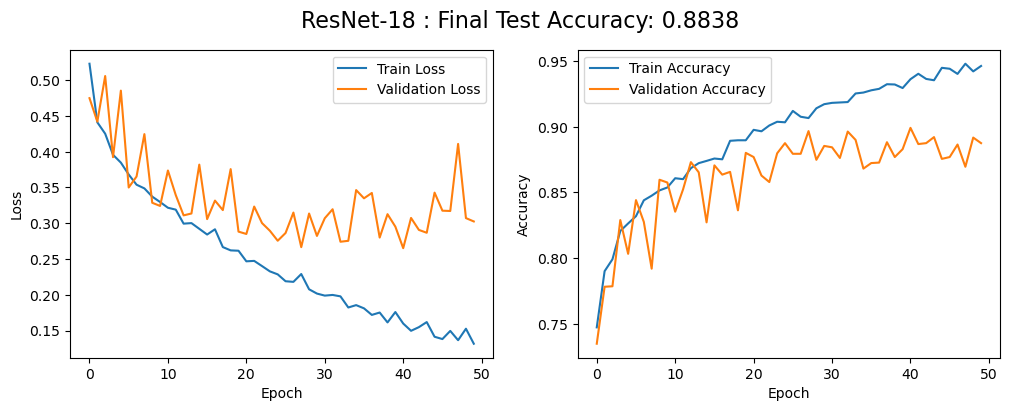

In [15]:
# Loss와 Accuracy 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 전체 그림의 제목
plt.suptitle("ResNet-18 : Final Test Accuracy: 0.8838", fontsize=16)
plt.savefig("D:/Working_Directory/project_0912/data/ResNet_18.png")
plt.show()

In [8]:
# 테스트 데이터셋을 사용하여 모델 최종 성능 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Test Accuracy: 0.8838


In [16]:
# ResNet-18 Model 저장
torch.save(model.state_dict(), 'D:/Working_Directory/project_0912/model/resnet18_model.pth')

## SqueezeNet


In [18]:
# (2) Modelling

# 1. SqueezeNet 모델 불러오기 (pre-trained 모델)
model = torchvision.models.squeezenet1_0(pretrained=True)

# 모델의 마지막 fully connected layer를 변경하여 클래스 수에 맞게 조정
num_classes = len(class_names)  # 클래스 수에 맞게 설정
model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

# GPU를 사용할 수 있다면 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# epochs, learning rate
num_epochs = 50
learning_rate = 0.001

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss, acc
train_losses = [] ;val_losses = []
train_accuracy = [] ;val_accuracy = []

# 모델 학습
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 30)

    # 학습 모드로 설정
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # tqdm으로 래핑한 데이터 로더
    train_dataloader = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch [{epoch+1}/{num_epochs}] - Train')

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # tqdm 업데이트 (진행률 표시)
        train_dataloader.set_postfix(loss=running_train_loss / (len(train_dataloader)), acc=correct_train / total_train)

    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy.append(correct_train / total_train)
    train_losses.append(epoch_train_loss)

    # 평가 모드로 설정
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_accuracy.append(correct_val / total_val)
    val_losses.append(epoch_val_loss)

    # 모델 체크포인트 저장 (필요한 경우)
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }
    checkpoint_path = "D:/Working_Directory/project_0912/model/checkpoint.pth"
    torch.save(checkpoint, checkpoint_path)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {train_accuracy[-1]:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {val_accuracy[-1]:.4f}')
    print('=' * 30)

Epoch 0/49
------------------------------


Epoch [1/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:30<00:00,  1.88it/s, acc=0.654, loss=0.586]


Epoch [1/50] - Train Loss: 0.5856 - Train Accuracy: 0.6542
Epoch [1/50] - Val Loss: 0.6931 - Val Accuracy: 0.3822
Epoch 1/49
------------------------------


Epoch [2/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:20<00:00,  1.94it/s, acc=0.722, loss=0.525]


Epoch [2/50] - Train Loss: 0.5252 - Train Accuracy: 0.7219
Epoch [2/50] - Val Loss: 0.6931 - Val Accuracy: 0.3822
Epoch 2/49
------------------------------


Epoch [3/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:17<00:00,  1.96it/s, acc=0.753, loss=0.488]


Epoch [3/50] - Train Loss: 0.4880 - Train Accuracy: 0.7531
Epoch [3/50] - Val Loss: 0.6931 - Val Accuracy: 0.3822
Epoch 3/49
------------------------------


Epoch [4/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.773, loss=0.466]


Epoch [4/50] - Train Loss: 0.4657 - Train Accuracy: 0.7730
Epoch [4/50] - Val Loss: 0.6932 - Val Accuracy: 0.3815
Epoch 4/49
------------------------------


Epoch [5/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:17<00:00,  1.95it/s, acc=0.78, loss=0.454]


Epoch [5/50] - Train Loss: 0.4540 - Train Accuracy: 0.7803
Epoch [5/50] - Val Loss: 0.6932 - Val Accuracy: 0.3819
Epoch 5/49
------------------------------


Epoch [6/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:27<00:00,  1.90it/s, acc=0.786, loss=0.439]


Epoch [6/50] - Train Loss: 0.4394 - Train Accuracy: 0.7858
Epoch [6/50] - Val Loss: 0.6930 - Val Accuracy: 0.3819
Epoch 6/49
------------------------------


Epoch [7/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:23<00:00,  1.92it/s, acc=0.793, loss=0.434]


Epoch [7/50] - Train Loss: 0.4336 - Train Accuracy: 0.7928
Epoch [7/50] - Val Loss: 0.6846 - Val Accuracy: 0.5014
Epoch 7/49
------------------------------


Epoch [8/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.798, loss=0.43]


Epoch [8/50] - Train Loss: 0.4298 - Train Accuracy: 0.7975
Epoch [8/50] - Val Loss: 0.6931 - Val Accuracy: 0.3963
Epoch 8/49
------------------------------


Epoch [9/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:06<00:00,  2.03it/s, acc=0.809, loss=0.41]


Epoch [9/50] - Train Loss: 0.4096 - Train Accuracy: 0.8091
Epoch [9/50] - Val Loss: 0.6593 - Val Accuracy: 0.6439
Epoch 9/49
------------------------------


Epoch [10/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:05<00:00,  2.03it/s, acc=0.803, loss=0.415]


Epoch [10/50] - Train Loss: 0.4155 - Train Accuracy: 0.8033
Epoch [10/50] - Val Loss: 0.6484 - Val Accuracy: 0.5843
Epoch 10/49
------------------------------


Epoch [11/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:05<00:00,  2.03it/s, acc=0.819, loss=0.399]


Epoch [11/50] - Train Loss: 0.3994 - Train Accuracy: 0.8189
Epoch [11/50] - Val Loss: 0.6500 - Val Accuracy: 0.5578
Epoch 11/49
------------------------------


Epoch [12/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.814, loss=0.41]


Epoch [12/50] - Train Loss: 0.4102 - Train Accuracy: 0.8136
Epoch [12/50] - Val Loss: 0.6925 - Val Accuracy: 0.4108
Epoch 12/49
------------------------------


Epoch [13/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:09<00:00,  2.00it/s, acc=0.824, loss=0.388]


Epoch [13/50] - Train Loss: 0.3877 - Train Accuracy: 0.8240
Epoch [13/50] - Val Loss: 0.6494 - Val Accuracy: 0.7028
Epoch 13/49
------------------------------


Epoch [14/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.824, loss=0.385]


Epoch [14/50] - Train Loss: 0.3849 - Train Accuracy: 0.8239
Epoch [14/50] - Val Loss: 0.6763 - Val Accuracy: 0.5434
Epoch 14/49
------------------------------


Epoch [15/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.828, loss=0.379]


Epoch [15/50] - Train Loss: 0.3791 - Train Accuracy: 0.8277
Epoch [15/50] - Val Loss: 0.6635 - Val Accuracy: 0.6703
Epoch 15/49
------------------------------


Epoch [16/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.833, loss=0.376]


Epoch [16/50] - Train Loss: 0.3762 - Train Accuracy: 0.8330
Epoch [16/50] - Val Loss: 0.6741 - Val Accuracy: 0.4993
Epoch 16/49
------------------------------


Epoch [17/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:09<00:00,  2.01it/s, acc=0.829, loss=0.373]


Epoch [17/50] - Train Loss: 0.3733 - Train Accuracy: 0.8288
Epoch [17/50] - Val Loss: 0.6495 - Val Accuracy: 0.5011
Epoch 17/49
------------------------------


Epoch [18/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.838, loss=0.369]


Epoch [18/50] - Train Loss: 0.3687 - Train Accuracy: 0.8376
Epoch [18/50] - Val Loss: 0.6560 - Val Accuracy: 0.5106
Epoch 18/49
------------------------------


Epoch [19/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:09<00:00,  2.01it/s, acc=0.837, loss=0.367]


Epoch [19/50] - Train Loss: 0.3674 - Train Accuracy: 0.8371
Epoch [19/50] - Val Loss: 0.6360 - Val Accuracy: 0.6329
Epoch 19/49
------------------------------


Epoch [20/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.838, loss=0.362]


Epoch [20/50] - Train Loss: 0.3615 - Train Accuracy: 0.8383
Epoch [20/50] - Val Loss: 0.6479 - Val Accuracy: 0.5240
Epoch 20/49
------------------------------


Epoch [21/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.83, loss=0.38]


Epoch [21/50] - Train Loss: 0.3803 - Train Accuracy: 0.8299
Epoch [21/50] - Val Loss: 0.6852 - Val Accuracy: 0.4954
Epoch 21/49
------------------------------


Epoch [22/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.843, loss=0.356]


Epoch [22/50] - Train Loss: 0.3560 - Train Accuracy: 0.8427
Epoch [22/50] - Val Loss: 0.6509 - Val Accuracy: 0.5829
Epoch 22/49
------------------------------


Epoch [23/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.841, loss=0.354]


Epoch [23/50] - Train Loss: 0.3536 - Train Accuracy: 0.8412
Epoch [23/50] - Val Loss: 0.5833 - Val Accuracy: 0.6636
Epoch 23/49
------------------------------


Epoch [24/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:23<00:00,  1.92it/s, acc=0.847, loss=0.348]


Epoch [24/50] - Train Loss: 0.3475 - Train Accuracy: 0.8465
Epoch [24/50] - Val Loss: 0.6325 - Val Accuracy: 0.5977
Epoch 24/49
------------------------------


Epoch [25/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.842, loss=0.349]


Epoch [25/50] - Train Loss: 0.3495 - Train Accuracy: 0.8421
Epoch [25/50] - Val Loss: 0.5339 - Val Accuracy: 0.6738
Epoch 25/49
------------------------------


Epoch [26/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.839, loss=0.355]


Epoch [26/50] - Train Loss: 0.3553 - Train Accuracy: 0.8392
Epoch [26/50] - Val Loss: 0.5592 - Val Accuracy: 0.6883
Epoch 26/49
------------------------------


Epoch [27/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:06<00:00,  2.03it/s, acc=0.847, loss=0.347]


Epoch [27/50] - Train Loss: 0.3466 - Train Accuracy: 0.8474
Epoch [27/50] - Val Loss: 0.6100 - Val Accuracy: 0.6640
Epoch 27/49
------------------------------


Epoch [28/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:05<00:00,  2.03it/s, acc=0.85, loss=0.343]


Epoch [28/50] - Train Loss: 0.3427 - Train Accuracy: 0.8501
Epoch [28/50] - Val Loss: 0.4361 - Val Accuracy: 0.7863
Epoch 28/49
------------------------------


Epoch [29/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.847, loss=0.341]


Epoch [29/50] - Train Loss: 0.3406 - Train Accuracy: 0.8470
Epoch [29/50] - Val Loss: 0.5166 - Val Accuracy: 0.8353
Epoch 29/49
------------------------------


Epoch [30/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:15<00:00,  1.97it/s, acc=0.849, loss=0.342]


Epoch [30/50] - Train Loss: 0.3424 - Train Accuracy: 0.8486
Epoch [30/50] - Val Loss: 0.4497 - Val Accuracy: 0.7574
Epoch 30/49
------------------------------


Epoch [31/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.847, loss=0.337]


Epoch [31/50] - Train Loss: 0.3371 - Train Accuracy: 0.8468
Epoch [31/50] - Val Loss: 0.4049 - Val Accuracy: 0.8142
Epoch 31/49
------------------------------


Epoch [32/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.851, loss=0.331]


Epoch [32/50] - Train Loss: 0.3312 - Train Accuracy: 0.8508
Epoch [32/50] - Val Loss: 0.3800 - Val Accuracy: 0.8427
Epoch 32/49
------------------------------


Epoch [33/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.857, loss=0.325]


Epoch [33/50] - Train Loss: 0.3248 - Train Accuracy: 0.8570
Epoch [33/50] - Val Loss: 0.3964 - Val Accuracy: 0.8230
Epoch 33/49
------------------------------


Epoch [34/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.86, loss=0.326]


Epoch [34/50] - Train Loss: 0.3257 - Train Accuracy: 0.8597
Epoch [34/50] - Val Loss: 0.3751 - Val Accuracy: 0.8417
Epoch 34/49
------------------------------


Epoch [35/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.852, loss=0.333]


Epoch [35/50] - Train Loss: 0.3335 - Train Accuracy: 0.8519
Epoch [35/50] - Val Loss: 0.3428 - Val Accuracy: 0.8459
Epoch 35/49
------------------------------


Epoch [36/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:09<00:00,  2.01it/s, acc=0.854, loss=0.33]


Epoch [36/50] - Train Loss: 0.3299 - Train Accuracy: 0.8537
Epoch [36/50] - Val Loss: 0.4071 - Val Accuracy: 0.8092
Epoch 36/49
------------------------------


Epoch [37/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  2.00it/s, acc=0.855, loss=0.325]


Epoch [37/50] - Train Loss: 0.3251 - Train Accuracy: 0.8552
Epoch [37/50] - Val Loss: 0.3644 - Val Accuracy: 0.8360
Epoch 37/49
------------------------------


Epoch [38/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.856, loss=0.326]


Epoch [38/50] - Train Loss: 0.3261 - Train Accuracy: 0.8565
Epoch [38/50] - Val Loss: 0.3478 - Val Accuracy: 0.8484
Epoch 38/49
------------------------------


Epoch [39/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.855, loss=0.323]


Epoch [39/50] - Train Loss: 0.3229 - Train Accuracy: 0.8547
Epoch [39/50] - Val Loss: 0.3322 - Val Accuracy: 0.8516
Epoch 39/49
------------------------------


Epoch [40/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:09<00:00,  2.01it/s, acc=0.858, loss=0.322]


Epoch [40/50] - Train Loss: 0.3222 - Train Accuracy: 0.8578
Epoch [40/50] - Val Loss: 0.3620 - Val Accuracy: 0.8364
Epoch 40/49
------------------------------


Epoch [41/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:09<00:00,  2.01it/s, acc=0.86, loss=0.321]


Epoch [41/50] - Train Loss: 0.3208 - Train Accuracy: 0.8595
Epoch [41/50] - Val Loss: 0.3614 - Val Accuracy: 0.8396
Epoch 41/49
------------------------------


Epoch [42/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:11<00:00,  1.99it/s, acc=0.861, loss=0.32]


Epoch [42/50] - Train Loss: 0.3204 - Train Accuracy: 0.8614
Epoch [42/50] - Val Loss: 0.3707 - Val Accuracy: 0.8378
Epoch 42/49
------------------------------


Epoch [43/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:12<00:00,  1.99it/s, acc=0.863, loss=0.315]


Epoch [43/50] - Train Loss: 0.3152 - Train Accuracy: 0.8627
Epoch [43/50] - Val Loss: 0.3744 - Val Accuracy: 0.8371
Epoch 43/49
------------------------------


Epoch [44/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.857, loss=0.319]


Epoch [44/50] - Train Loss: 0.3190 - Train Accuracy: 0.8574
Epoch [44/50] - Val Loss: 0.4102 - Val Accuracy: 0.8114
Epoch 44/49
------------------------------


Epoch [45/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:08<00:00,  2.01it/s, acc=0.862, loss=0.318]


Epoch [45/50] - Train Loss: 0.3179 - Train Accuracy: 0.8620
Epoch [45/50] - Val Loss: 0.3700 - Val Accuracy: 0.8441
Epoch 45/49
------------------------------


Epoch [46/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:09<00:00,  2.00it/s, acc=0.86, loss=0.316]


Epoch [46/50] - Train Loss: 0.3156 - Train Accuracy: 0.8603
Epoch [46/50] - Val Loss: 0.3402 - Val Accuracy: 0.8494
Epoch 46/49
------------------------------


Epoch [47/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.863, loss=0.309]


Epoch [47/50] - Train Loss: 0.3092 - Train Accuracy: 0.8625
Epoch [47/50] - Val Loss: 0.3493 - Val Accuracy: 0.8441
Epoch 47/49
------------------------------


Epoch [48/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:07<00:00,  2.02it/s, acc=0.86, loss=0.321]


Epoch [48/50] - Train Loss: 0.3205 - Train Accuracy: 0.8596
Epoch [48/50] - Val Loss: 0.3858 - Val Accuracy: 0.8378
Epoch 48/49
------------------------------


Epoch [49/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:06<00:00,  2.02it/s, acc=0.858, loss=0.321]


Epoch [49/50] - Train Loss: 0.3211 - Train Accuracy: 0.8583
Epoch [49/50] - Val Loss: 0.3891 - Val Accuracy: 0.8198
Epoch 49/49
------------------------------


Epoch [50/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:10<00:00,  2.00it/s, acc=0.855, loss=0.324]


Epoch [50/50] - Train Loss: 0.3236 - Train Accuracy: 0.8548
Epoch [50/50] - Val Loss: 0.3464 - Val Accuracy: 0.8480


In [19]:
# 테스트 데이터셋을 사용하여 모델 최종 성능 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Final Test Accuracy: {test_accuracy:.4f}')

# ResNet-18 Model 저장
torch.save(model.state_dict(), 'D:/Working_Directory/project_0912/model/squeezenet_model.pth')

Final Test Accuracy: 0.8275


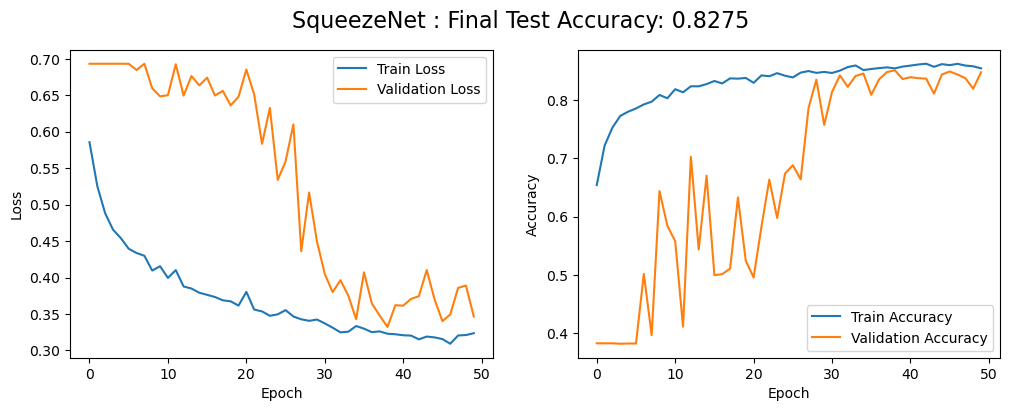

In [20]:
# Loss와 Accuracy 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 전체 그림의 제목
plt.suptitle("SqueezeNet : Final Test Accuracy: 0.8275", fontsize=16)
plt.savefig("D:/Working_Directory/project_0912/model/SqueezeNet.png")
plt.show()

## MobileNet

In [21]:
# (2) Modelling

# 1. MobileNet 모델 불러오기 (pre-trained 모델)
model = torchvision.models.mobilenet_v2(pretrained=True)

# 모델의 마지막 fully connected layer를 변경하여 클래스 수에 맞게 조정
num_classes = len(class_names)  # 클래스 수에 맞게 설정
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# GPU를 사용할 수 있다면 GPU로 모델 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# epochs, learning rate
num_epochs = 50
learning_rate = 0.001

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss, acc
train_losses = [] ;val_losses = []
train_accuracy = [] ;val_accuracy = []

# 모델 학습
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 30)

    # 학습 모드로 설정
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # tqdm으로 래핑한 데이터 로더
    train_dataloader = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch [{epoch+1}/{num_epochs}] - Train')

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # tqdm 업데이트 (진행률 표시)
        train_dataloader.set_postfix(loss=running_train_loss / (len(train_dataloader)), acc=correct_train / total_train)

    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_accuracy.append(correct_train / total_train)
    train_losses.append(epoch_train_loss)

    # 평가 모드로 설정
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_dataloader)
    val_accuracy.append(correct_val / total_val)
    val_losses.append(epoch_val_loss)

    # 모델 체크포인트 저장 (필요한 경우)
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }
    checkpoint_path = "D:/Working_Directory/project_0912/model/checkpoint.pth"
    torch.save(checkpoint, checkpoint_path)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {train_accuracy[-1]:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {val_accuracy[-1]:.4f}')
    print('=' * 30)

C:\Users\Minwoo\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Minwoo/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 11.2MB/s]


Epoch 0/49
------------------------------


Epoch [1/50] - Train: 100%|████████████████████████████████████████████████| 621/621 [06:08<00:00,  1.68it/s, acc=0.8, loss=0.431]


Epoch [1/50] - Train Loss: 0.4307 - Train Accuracy: 0.8003
Epoch [1/50] - Val Loss: 0.3454 - Val Accuracy: 0.8399
Epoch 1/49
------------------------------


Epoch [2/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:37<00:00,  1.84it/s, acc=0.831, loss=0.374]


Epoch [2/50] - Train Loss: 0.3737 - Train Accuracy: 0.8305
Epoch [2/50] - Val Loss: 0.3255 - Val Accuracy: 0.8738
Epoch 2/49
------------------------------


Epoch [3/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:38<00:00,  1.84it/s, acc=0.847, loss=0.351]


Epoch [3/50] - Train Loss: 0.3515 - Train Accuracy: 0.8465
Epoch [3/50] - Val Loss: 0.3688 - Val Accuracy: 0.8350
Epoch 3/49
------------------------------


Epoch [4/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [07:14<00:00,  1.43it/s, acc=0.853, loss=0.34]


Epoch [4/50] - Train Loss: 0.3397 - Train Accuracy: 0.8533
Epoch [4/50] - Val Loss: 0.2990 - Val Accuracy: 0.8713
Epoch 4/49
------------------------------


Epoch [5/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [07:20<00:00,  1.41it/s, acc=0.861, loss=0.325]


Epoch [5/50] - Train Loss: 0.3248 - Train Accuracy: 0.8611
Epoch [5/50] - Val Loss: 0.3199 - Val Accuracy: 0.8593
Epoch 5/49
------------------------------


Epoch [6/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [06:46<00:00,  1.53it/s, acc=0.863, loss=0.315]


Epoch [6/50] - Train Loss: 0.3153 - Train Accuracy: 0.8632
Epoch [6/50] - Val Loss: 0.3226 - Val Accuracy: 0.8646
Epoch 6/49
------------------------------


Epoch [7/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [08:10<00:00,  1.27it/s, acc=0.865, loss=0.313]


Epoch [7/50] - Train Loss: 0.3129 - Train Accuracy: 0.8653
Epoch [7/50] - Val Loss: 0.2872 - Val Accuracy: 0.8762
Epoch 7/49
------------------------------


Epoch [8/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [06:18<00:00,  1.64it/s, acc=0.871, loss=0.302]


Epoch [8/50] - Train Loss: 0.3016 - Train Accuracy: 0.8713
Epoch [8/50] - Val Loss: 0.2871 - Val Accuracy: 0.8745
Epoch 8/49
------------------------------


Epoch [9/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [06:15<00:00,  1.65it/s, acc=0.88, loss=0.287]


Epoch [9/50] - Train Loss: 0.2875 - Train Accuracy: 0.8800
Epoch [9/50] - Val Loss: 0.2627 - Val Accuracy: 0.8865
Epoch 9/49
------------------------------


Epoch [10/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:49<00:00,  1.78it/s, acc=0.88, loss=0.286]


Epoch [10/50] - Train Loss: 0.2862 - Train Accuracy: 0.8797
Epoch [10/50] - Val Loss: 0.2738 - Val Accuracy: 0.8882
Epoch 10/49
------------------------------


Epoch [11/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:53<00:00,  1.75it/s, acc=0.882, loss=0.282]


Epoch [11/50] - Train Loss: 0.2816 - Train Accuracy: 0.8819
Epoch [11/50] - Val Loss: 0.2933 - Val Accuracy: 0.8794
Epoch 11/49
------------------------------


Epoch [12/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:42<00:00,  1.81it/s, acc=0.885, loss=0.278]


Epoch [12/50] - Train Loss: 0.2776 - Train Accuracy: 0.8854
Epoch [12/50] - Val Loss: 0.2458 - Val Accuracy: 0.8939
Epoch 12/49
------------------------------


Epoch [13/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:45<00:00,  1.80it/s, acc=0.893, loss=0.257]


Epoch [13/50] - Train Loss: 0.2566 - Train Accuracy: 0.8933
Epoch [13/50] - Val Loss: 0.2688 - Val Accuracy: 0.8900
Epoch 13/49
------------------------------


Epoch [14/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:50<00:00,  1.77it/s, acc=0.892, loss=0.262]


Epoch [14/50] - Train Loss: 0.2624 - Train Accuracy: 0.8917
Epoch [14/50] - Val Loss: 0.2527 - Val Accuracy: 0.8960
Epoch 14/49
------------------------------


Epoch [15/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:46<00:00,  1.79it/s, acc=0.892, loss=0.254]


Epoch [15/50] - Train Loss: 0.2544 - Train Accuracy: 0.8924
Epoch [15/50] - Val Loss: 0.2943 - Val Accuracy: 0.8798
Epoch 15/49
------------------------------


Epoch [16/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:01<00:00,  1.72it/s, acc=0.893, loss=0.259]


Epoch [16/50] - Train Loss: 0.2591 - Train Accuracy: 0.8932
Epoch [16/50] - Val Loss: 0.2735 - Val Accuracy: 0.8882
Epoch 16/49
------------------------------


Epoch [17/50] - Train: 100%|███████████████████████████████████████████████| 621/621 [06:04<00:00,  1.70it/s, acc=0.9, loss=0.244]


Epoch [17/50] - Train Loss: 0.2437 - Train Accuracy: 0.8999
Epoch [17/50] - Val Loss: 0.2539 - Val Accuracy: 0.8893
Epoch 17/49
------------------------------


Epoch [18/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:59<00:00,  1.73it/s, acc=0.903, loss=0.236]


Epoch [18/50] - Train Loss: 0.2365 - Train Accuracy: 0.9034
Epoch [18/50] - Val Loss: 0.2433 - Val Accuracy: 0.9041
Epoch 18/49
------------------------------


Epoch [19/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:58<00:00,  1.73it/s, acc=0.902, loss=0.24]


Epoch [19/50] - Train Loss: 0.2400 - Train Accuracy: 0.9016
Epoch [19/50] - Val Loss: 0.2372 - Val Accuracy: 0.9013
Epoch 19/49
------------------------------


Epoch [20/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:00<00:00,  1.72it/s, acc=0.903, loss=0.241]


Epoch [20/50] - Train Loss: 0.2405 - Train Accuracy: 0.9026
Epoch [20/50] - Val Loss: 0.2535 - Val Accuracy: 0.8995
Epoch 20/49
------------------------------


Epoch [21/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:53<00:00,  1.75it/s, acc=0.902, loss=0.235]


Epoch [21/50] - Train Loss: 0.2352 - Train Accuracy: 0.9016
Epoch [21/50] - Val Loss: 0.2433 - Val Accuracy: 0.9044
Epoch 21/49
------------------------------


Epoch [22/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [07:37<00:00,  1.36it/s, acc=0.905, loss=0.23]


Epoch [22/50] - Train Loss: 0.2304 - Train Accuracy: 0.9055
Epoch [22/50] - Val Loss: 0.2568 - Val Accuracy: 0.8942
Epoch 22/49
------------------------------


Epoch [23/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:50<00:00,  1.51it/s, acc=0.909, loss=0.225]


Epoch [23/50] - Train Loss: 0.2246 - Train Accuracy: 0.9087
Epoch [23/50] - Val Loss: 0.2470 - Val Accuracy: 0.9030
Epoch 23/49
------------------------------


Epoch [24/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:47<00:00,  1.79it/s, acc=0.911, loss=0.216]


Epoch [24/50] - Train Loss: 0.2164 - Train Accuracy: 0.9111
Epoch [24/50] - Val Loss: 0.2297 - Val Accuracy: 0.9076
Epoch 24/49
------------------------------


Epoch [25/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:42<00:00,  1.81it/s, acc=0.914, loss=0.21]


Epoch [25/50] - Train Loss: 0.2103 - Train Accuracy: 0.9140
Epoch [25/50] - Val Loss: 0.2351 - Val Accuracy: 0.8999
Epoch 25/49
------------------------------


Epoch [26/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:40<00:00,  1.82it/s, acc=0.914, loss=0.21]


Epoch [26/50] - Train Loss: 0.2097 - Train Accuracy: 0.9145
Epoch [26/50] - Val Loss: 0.2399 - Val Accuracy: 0.9083
Epoch 26/49
------------------------------


Epoch [27/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:39<00:00,  1.83it/s, acc=0.913, loss=0.211]


Epoch [27/50] - Train Loss: 0.2106 - Train Accuracy: 0.9133
Epoch [27/50] - Val Loss: 0.2593 - Val Accuracy: 0.9034
Epoch 27/49
------------------------------


Epoch [28/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:38<00:00,  1.83it/s, acc=0.922, loss=0.192]


Epoch [28/50] - Train Loss: 0.1919 - Train Accuracy: 0.9222
Epoch [28/50] - Val Loss: 0.2150 - Val Accuracy: 0.9115
Epoch 28/49
------------------------------


Epoch [29/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:36<00:00,  1.85it/s, acc=0.916, loss=0.206]


Epoch [29/50] - Train Loss: 0.2063 - Train Accuracy: 0.9160
Epoch [29/50] - Val Loss: 0.3392 - Val Accuracy: 0.8734
Epoch 29/49
------------------------------


Epoch [30/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:38<00:00,  1.83it/s, acc=0.915, loss=0.215]


Epoch [30/50] - Train Loss: 0.2154 - Train Accuracy: 0.9151
Epoch [30/50] - Val Loss: 0.2585 - Val Accuracy: 0.8956
Epoch 30/49
------------------------------


Epoch [31/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:41<00:00,  1.82it/s, acc=0.924, loss=0.194]


Epoch [31/50] - Train Loss: 0.1936 - Train Accuracy: 0.9241
Epoch [31/50] - Val Loss: 0.2267 - Val Accuracy: 0.9133
Epoch 31/49
------------------------------


Epoch [32/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:40<00:00,  1.83it/s, acc=0.922, loss=0.197]


Epoch [32/50] - Train Loss: 0.1968 - Train Accuracy: 0.9224
Epoch [32/50] - Val Loss: 0.2308 - Val Accuracy: 0.9087
Epoch 32/49
------------------------------


Epoch [33/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:38<00:00,  1.84it/s, acc=0.927, loss=0.181]


Epoch [33/50] - Train Loss: 0.1813 - Train Accuracy: 0.9273
Epoch [33/50] - Val Loss: 0.2202 - Val Accuracy: 0.9111
Epoch 33/49
------------------------------


Epoch [34/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:41<00:00,  1.82it/s, acc=0.93, loss=0.181]


Epoch [34/50] - Train Loss: 0.1809 - Train Accuracy: 0.9304
Epoch [34/50] - Val Loss: 0.2287 - Val Accuracy: 0.9044
Epoch 34/49
------------------------------


Epoch [35/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:38<00:00,  1.83it/s, acc=0.931, loss=0.176]


Epoch [35/50] - Train Loss: 0.1757 - Train Accuracy: 0.9311
Epoch [35/50] - Val Loss: 0.2894 - Val Accuracy: 0.9016
Epoch 35/49
------------------------------


Epoch [36/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:59<00:00,  1.73it/s, acc=0.93, loss=0.175]


Epoch [36/50] - Train Loss: 0.1752 - Train Accuracy: 0.9300
Epoch [36/50] - Val Loss: 0.2257 - Val Accuracy: 0.9161
Epoch 36/49
------------------------------


Epoch [37/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:54<00:00,  1.75it/s, acc=0.93, loss=0.175]


Epoch [37/50] - Train Loss: 0.1754 - Train Accuracy: 0.9303
Epoch [37/50] - Val Loss: 0.2225 - Val Accuracy: 0.9111
Epoch 37/49
------------------------------


Epoch [38/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:39<00:00,  1.83it/s, acc=0.929, loss=0.176]


Epoch [38/50] - Train Loss: 0.1765 - Train Accuracy: 0.9285
Epoch [38/50] - Val Loss: 0.2151 - Val Accuracy: 0.9168
Epoch 38/49
------------------------------


Epoch [39/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:05<00:00,  1.70it/s, acc=0.937, loss=0.162]


Epoch [39/50] - Train Loss: 0.1623 - Train Accuracy: 0.9368
Epoch [39/50] - Val Loss: 0.2253 - Val Accuracy: 0.9087
Epoch 39/49
------------------------------


Epoch [40/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:57<00:00,  1.74it/s, acc=0.932, loss=0.165]


Epoch [40/50] - Train Loss: 0.1649 - Train Accuracy: 0.9322
Epoch [40/50] - Val Loss: 0.2244 - Val Accuracy: 0.9168
Epoch 40/49
------------------------------


Epoch [41/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:00<00:00,  1.72it/s, acc=0.935, loss=0.159]


Epoch [41/50] - Train Loss: 0.1589 - Train Accuracy: 0.9355
Epoch [41/50] - Val Loss: 0.2386 - Val Accuracy: 0.9076
Epoch 41/49
------------------------------


Epoch [42/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:46<00:00,  1.79it/s, acc=0.937, loss=0.16]


Epoch [42/50] - Train Loss: 0.1599 - Train Accuracy: 0.9371
Epoch [42/50] - Val Loss: 0.2194 - Val Accuracy: 0.9168
Epoch 42/49
------------------------------


Epoch [43/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [06:02<00:00,  1.71it/s, acc=0.936, loss=0.168]


Epoch [43/50] - Train Loss: 0.1683 - Train Accuracy: 0.9356
Epoch [43/50] - Val Loss: 0.2523 - Val Accuracy: 0.9073
Epoch 43/49
------------------------------


Epoch [44/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:59<00:00,  1.73it/s, acc=0.937, loss=0.16]


Epoch [44/50] - Train Loss: 0.1599 - Train Accuracy: 0.9369
Epoch [44/50] - Val Loss: 0.2424 - Val Accuracy: 0.9094
Epoch 44/49
------------------------------


Epoch [45/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:43<00:00,  1.81it/s, acc=0.937, loss=0.159]


Epoch [45/50] - Train Loss: 0.1586 - Train Accuracy: 0.9371
Epoch [45/50] - Val Loss: 0.2075 - Val Accuracy: 0.9228
Epoch 45/49
------------------------------


Epoch [46/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:45<00:00,  1.80it/s, acc=0.941, loss=0.151]


Epoch [46/50] - Train Loss: 0.1506 - Train Accuracy: 0.9410
Epoch [46/50] - Val Loss: 0.2627 - Val Accuracy: 0.9087
Epoch 46/49
------------------------------


Epoch [47/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:43<00:00,  1.81it/s, acc=0.936, loss=0.16]


Epoch [47/50] - Train Loss: 0.1604 - Train Accuracy: 0.9364
Epoch [47/50] - Val Loss: 0.2305 - Val Accuracy: 0.9164
Epoch 47/49
------------------------------


Epoch [48/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:45<00:00,  1.80it/s, acc=0.937, loss=0.158]


Epoch [48/50] - Train Loss: 0.1582 - Train Accuracy: 0.9366
Epoch [48/50] - Val Loss: 0.2288 - Val Accuracy: 0.9104
Epoch 48/49
------------------------------


Epoch [49/50] - Train: 100%|█████████████████████████████████████████████| 621/621 [05:43<00:00,  1.81it/s, acc=0.942, loss=0.147]


Epoch [49/50] - Train Loss: 0.1472 - Train Accuracy: 0.9417
Epoch [49/50] - Val Loss: 0.2290 - Val Accuracy: 0.9182
Epoch 49/49
------------------------------


Epoch [50/50] - Train: 100%|██████████████████████████████████████████████| 621/621 [05:41<00:00,  1.82it/s, acc=0.941, loss=0.15]


Epoch [50/50] - Train Loss: 0.1496 - Train Accuracy: 0.9413
Epoch [50/50] - Val Loss: 0.2347 - Val Accuracy: 0.9122


In [22]:
# 테스트 데이터셋을 사용하여 모델 최종 성능 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Final Test Accuracy: {test_accuracy:.4f}')

# mobilenet Model 저장
torch.save(model.state_dict(), 'D:/Working_Directory/project_0912/model/mobilenet_model.pth')

Final Test Accuracy: 0.9049


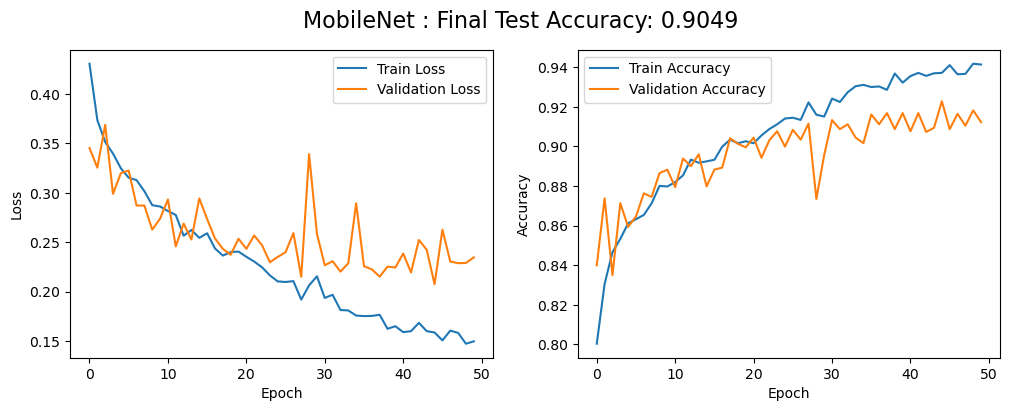

In [23]:
# Loss와 Accuracy 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 전체 그림의 제목
plt.suptitle("MobileNet : Final Test Accuracy: 0.9049", fontsize=16)
plt.savefig("D:/Working_Directory/project_0912/data/MobileNet.png")
plt.show()